## Example to load the network, sample 4 levels at random from the latent space and then plot them using matplotlib.


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!cp 'path/to/file' 'path/to/drive'

In [3]:
import os
os.chdir("exercise_DL_pcg")

In [4]:
!dir

 Volume in drive C is Windows-SSD
 Volume Serial Number is 8E0E-DA26

 Directory of c:\Users\lux_-\Desktop\MAI - Labs\modern-ai-course\lecture-09\exercise_DL_pcg

29/09/2021  13.50    <DIR>          .
29/09/2021  13.50    <DIR>          ..
15/09/2021  20.28        46.794.090 all_levels_onehot.npz
15/09/2021  21.16               821 example_sampling_random_levels.py
15/09/2021  21.16    <DIR>          models
29/09/2021  17.32             2.377 plotting_utilities.py
15/09/2021  21.18             1.003 readme.md
15/09/2021  21.17               255 requirements.txt
15/09/2021  20.50    <DIR>          sprites
15/09/2021  20.47             4.526 train_vae.py
15/09/2021  21.09             1.966 vae_mario.py
29/09/2021  17.30    <DIR>          __pycache__
               7 File(s)     46.805.038 bytes
               5 Dir(s)  437.737.181.184 bytes free


In [5]:
import os
import torch
import matplotlib.pyplot as plt

from vae_mario import VAEMario
from plotting_utilities import plot_decoded_level
from plotting_utilities import get_decoded_level

In [6]:
# Loading the model
model_name = "mario_vae_zdim_2_overfitted"
z_dim = 2
vae = VAEMario(z_dim=z_dim)
vae.load_state_dict(torch.load(f"./models/{model_name}.pt"))


VAEMario(
  (encoder): Sequential(
    (0): Linear(in_features=2156, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (fc_var): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2156, bias=True)
  )
)


<All keys matched successfully>

In [7]:
# Sampling random zs
zs = 2.5 * torch.randn((1, z_dim))
print(zs)

tensor([[-0.3011, -0.1880]])


In [50]:
# Getting levels from them using the decoder
levels = vae.decode(bestGene)
# print(levels.shape)
level_imgs = [plot_decoded_level(level) for level in levels]


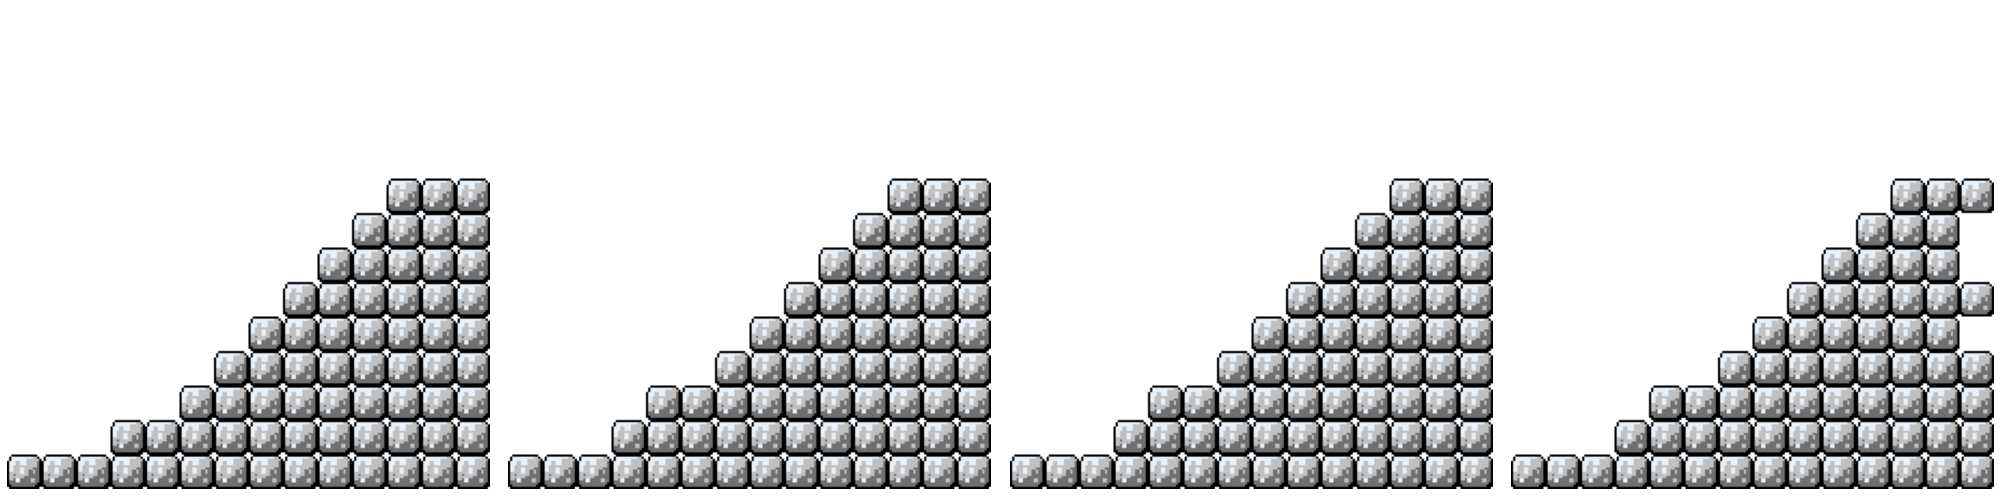

In [51]:
# Plotting
_, axes = plt.subplots(1, 4, figsize=(7 * 4, 7))
for level_img, ax in zip(level_imgs, axes):
    ax.imshow(level_img)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [10]:
# Sampling random zs


In [49]:
import random
import copy
popCount = 100
mutateStep = 0.05
randomSampleChance = 0.05

def calcFitness(gene):
    tensor = torch.Tensor([gene])
    levelses = vae.decode(tensor)
    decoded = [get_decoded_level(level) for level in levelses]
    numOfDirt = 0
    for v in decoded[0]:
        if v == 0:
            numOfDirt += 1
    return numOfDirt / len(decoded[0])

def generatePopulation(popCount):
    population = [0]*popCount
    for i in range(popCount):
        population[i] = ([5*random.uniform(0,1), 5*random.uniform(0,1)], -1)
    return population
        

def recombination(a, b):
    (geneA, _) = a
    (geneB, _) = b
    geneA0 = geneA[0]
    geneA[0] = geneB[0]
    geneB[0] = geneA0
    return ((geneA, -1), (geneB, -1))

def mutation(a):
    (gene, _) = a
    gene[random.randint(0, 1)] += (mutateStep if random.uniform(0,1) > 0.5 else -mutateStep)
    return (gene, -1)

def selectHighestFitness(population, withRandom, best):
    explore = 0
    if withRandom:
        explore = random.uniform(0,1)
    if explore < randomSampleChance:
        return population[random.randint(0, len(population)-1)]
    else:
        bestGene = []
        bestFitness = -1 if best else 1000
        for i, (gene, fitness) in enumerate(population):
            if (fitness > bestFitness and best) or (fitness < bestFitness and not best):
                bestGene = gene
                bestFitness = fitness
        return (bestGene, bestFitness)
                

def selectGenes(amount, population, withRandom, best):
    genes = [0]*amount
    fakePop = copy.deepcopy(population)
    for i in range(amount):
        genes[i] = selectHighestFitness(fakePop, withRandom, best)
        fakePop.remove(genes[i])
    return genes

def trimPopulation(population):
    deadMen = selectGenes(len(population) - 100, population, False, False)
    for deadMan in deadMen:
        population.remove(deadMan)
    return population

def evovle(evolutions):
    population = generatePopulation(popCount)
    bestGene = None
    for _ in range (evolutions):
        for i, (gene, fit) in enumerate(population):
            if fit == -1:
                fitness = calcFitness(gene)
                population[i] = (gene, fitness)
        mutants = [mutation(gene) for gene in selectGenes(5, population, True, True)]
        parents = selectGenes(6, population, True, True)
        children = []
        for parent1, parent2 in zip(parents[0::2], parents[1::2]):
            child1, child2 = recombination(parent1, parent2)
            children.append(child1)
            children.append(child2)

        newComers = mutants + children
        for i, (gene, fit) in enumerate(newComers):
            if fit == -1:
                fitness = calcFitness(gene)
                newComers[i] = (gene, fitness)

        tooBigPopulation = population + newComers
        population = trimPopulation(tooBigPopulation)

        bestGeneAndFit = selectGenes(4, population, False, True)
    bestGenes =[gene for (gene, fit) in bestGeneAndFit]
    print(bestGenes)
    return torch.Tensor([bestGenes])

bestGene = evovle(1000)


[[2.5697364618407765, -1.5089542532894151], [2.5197364618407767, -1.5089542532894151], [2.5197364618407767, -1.5089542532894151], [2.469736461840777, -1.5089542532894151]]


# Latent Variable Evolution Lab


## Sample from the VAE and then implement some search algorithm of choise to search the latent space for a particular level (e.g. one with many ground tiles)